### Notes:

* python script stores result of the simulation in a predetermined location
* jupyter notebook shows visualizations of the results from solidity implementation and cadCAD model and error metrics

In [1]:
from pathlib import Path
import os

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import pandas as pd
import datetime as dt
from enum import Enum
import csv

import sys
sys.path.append('./models')

In [3]:
# market_price_df = pd.read_csv('./tests/data/regression_market_prices.csv')
# market_price_df = pd.read_csv('./tests/data/market_prices.csv')
# market_prices = market_price_df['market_price'].apply(lambda x: float(x)).to_list()

import csv
with open('./tests/data/historic_market_prices.csv', newline='') as f:
    reader = csv.reader(f)
    market_prices = list(reader)[0]
    market_prices = [float(price) for price in market_prices]

# with open('./tests/data/historic_market_prices.csv', 'w') as market_prices_csv:
#     wr = csv.writer(market_prices_csv, delimiter=',')
#     wr.writerow(market_prices)

In [4]:
#python stores a file containing Kp, Ki and a time series of market prices 
#(an array of tuples, or two arrays, containing a timestamp and the price, 
#or the time elapsed and the price change - we can go with whatever is easier to implement on the JS side)

#instead of file name being hardcoded, we could have it stored in an environment 
#variable that both python and JS read from
Kp = 5e-7
Ki = -1e-7
per_second_leak = 1000000000000000000000000000
control_period = 3600

length = len(market_prices)
delta_t = [control_period] * length
SIMULATION_TIMESTEPS = length - 1

save_dir = "../truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"

config_file = {
  "Kp": str(int(Kp * 1e18)),
  "Ki": str(int(Ki * 1e18 / control_period)),
  "noise_barrier": "1000000000000000000",
  "per_second_leak": str(int(per_second_leak)),
  "oracle_initial_price": "2000000000000000000",
  "initial_redemption_price": "2000000000000000000000000000",
  "delta_t": [str(i) for i in delta_t],
  "market_prices": [str(int(i*1e18)) for i in market_prices],
  "save_dir": save_dir
}

import json
with open('./cross-model/truffle/test/config/pi_second_raw.json', 'w') as fp:
    json.dump(config_file, fp)
    
config_file = {
  "alpha": per_second_leak,
  "kp": Kp,
  "ki": lambda control_period=control_period: Ki/control_period,
  "delta_t": delta_t,
  "market_prices": market_prices,
}

In [5]:
market_prices[0:5]

[2.03520968321892,
 2.00675297061406,
 2.02594470965992,
 2.05147525236802,
 1.94445601467646]

In [6]:
# Compile, test, and deploy contracts to Ganache
# !npm run pi-raw-second-imported-config --prefix './cross-model/truffle'

import os
os.chdir('./cross-model/truffle')
!npm run install-deps
!npm run pi-raw-second-imported-config
import os
os.chdir('../../')


> geb-rrfm-truffle-sims@1.0.0 install-deps /Users/bscholtz/workspace/reflexer/cross-model/truffle
> npm install

npm WARN geb-rrfm-truffle-sims@1.0.0 No repository field.
npm WARN geb-rrfm-truffle-sims@1.0.0 license should be a valid SPDX license expression

audited 363 packages in 3.01s

7 packages are looking for funding
  run `npm fund` for details

found 1 low severity vulnerability
  run `npm audit fix` to fix them, or `npm audit` for details

> geb-rrfm-truffle-sims@1.0.0 pi-raw-second-imported-config /Users/bscholtz/workspace/reflexer/cross-model/truffle
> npx truffle test test/pi_raw_second_imported_config.js

- Fetching solc version list from solc-bin. Attempt #1

Compiling your contracts...
> Compiling ./cross-model/truffle/contracts/Migrations.sol
> Compiling ./cross-model/truffle/contracts/calculator/math/SafeMath.sol
> Compiling ./cross-model/truffle/contracts/calculator/math/SignedSafeMath.sol
> Compiling ./cross-model/truffle/contracts/calculator/per-second/raw/PIRawPer

[redemptionRate](https://github.com/reflexer-labs/geb-rrfm-truffle-sims/blob/master/contracts/mock/MockOracleRelayer.sol#L14) = $1+d_t$ (units: per second)  
$p_{t+\Delta{t}} = p_{t} (1+d_t)^{\Delta{t}}$ where $\Delta{t}$ is measured in seconds  
Meaning:
* $d_t > 0$ implies $redemptionRate > 1$  
* $d_t < 0$ implies $redemptionRate < 1$  


In the results dataset this is the PerSecondRedemptionRate column

In [7]:
from models.system_model_v1.model.state_variables import state_variables

def pre_process_initial_conditions(genesis_dict):
    base_genesis_states = genesis_dict.copy()
    for k in base_genesis_states.keys():
        if k in config_file:
            try:
                base_genesis_states[k] = config_file[k][0]
            except:
                base_genesis_states[k] = config_file[k]
    return base_genesis_states

test_specific_initial_conditions = pre_process_initial_conditions(state_variables)

In [8]:
from models.system_model_v1.model.parts.sys_params import params

def pre_process_params_dict(params_dict):
    base_params_dict = params_dict.copy()
    for k in config_file.keys():
        if type(config_file[k]) == list:
            base_params_dict[k] = [config_file[k]]
        else:
            try:
                base_params_dict[k] = [config_file[k]]
            except OverflowError:
                print(config_file[k])
                raise
    return base_params_dict

test_specific_params = pre_process_params_dict(params)

In [9]:
# T = 0
# for k in config_file.keys():
#     if type(config_file[k]) == list:
#         T = len(config_file[k])-1
#         break

In [10]:
def test_specific_resolve_time_passed(params, substep, state_history, state):
    index = state['timestep']+1
    value = params['delta_t'][index]
    return {'seconds_passed': value}

def test_specific_update_market_price(params, substep, state_history, state, policy_input):
    key = 'market_price'  
    index = state['timestep']
    value = params['market_prices'][index]
    return key, value


from models.system_model_v1.model.parts.markets import resolve_time_passed, update_market_price
from models.system_model_v1.model.partial_state_update_blocks import partial_state_update_blocks

for psub in partial_state_update_blocks:
    for psub_part in psub.values():
        if type(psub_part)==dict:
            for k,v in psub_part.items():
                if v == resolve_time_passed:
                    psub_part[k] = test_specific_resolve_time_passed
                if v == update_market_price:
                    psub_part[k] = test_specific_update_market_price

In [11]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

del configs[:]

exp = Experiment()

sim_config_dict = {
    'T': range(SIMULATION_TIMESTEPS),
    'N': 1,
    'M': test_specific_params
}
c = config_sim(sim_config_dict)

exp.append_configs(
    initial_state=test_specific_initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=c #preprocessed dictionaries containing simulation parameters
)

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (651, 24, 1, 15)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.34s


In [12]:
full = pd.DataFrame(raw_result)

In [13]:
max_substep = max(full.substep)
df = full.copy()
df = df[(df.substep==max_substep) | (df.substep==0)]

In [14]:
save_dir = "./cross-model/truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"
data = pd.read_csv(save_dir, sep=" ", header=None, skiprows=1)
data.columns = [x.replace(' ','') for x in pd.read_csv(save_dir, sep="|", nrows=1).columns]

for c in data.columns:
    data[c]=data[c].apply(float)
#define normalizing constants
WAD = 10**18
RAY = 10**27
RAD = 10**45
#normalize data to "USD" dimension
data['MarketPrice(USD)'] = data['MarketPrice(WAD)']/WAD
data['RedemptionPrice(USD)'] = data['RedemptionPrice(RAY)']/RAY
data['PerSecondRedemptionRate(float)'] = data['PerSecondRedemptionRate(RAY)']/RAY - 1
data['time'] = data['DelaySinceLastUpdate'].cumsum()
data['timestamp'] = state_variables['timestamp'] + data['time'].apply(lambda x: dt.timedelta(seconds=x))

In [15]:
df

,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,target_price,market_price,debt_price,timedelta,timestamp,blockheight,simulation,subset,run,substep,timestep
0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000,2.000000,2.000000,0,2018-12-18 00:00:00,0,0,0,1,0,0
6,0.000000,0.001281,0.0,0.0,0.000000,2.306386,0.000000,0.000000,0.000000e+00,2.000000,2.006753,2.001281,3600,2018-12-18 01:00:00,240,0,0,1,6,1
12,-0.006753,-0.004901,0.0,0.0,-12.155347,-4.209400,-0.000002,-0.000002,-3.038837e-09,1.999978,2.025945,2.001852,3600,2018-12-18 02:00:00,480,0,0,1,6,2
18,-0.025967,-0.024532,0.0,0.0,-70.895208,-57.189355,-0.000005,-0.000005,-1.101398e-08,1.999899,2.051475,2.001413,3600,2018-12-18 03:00:00,720,0,0,1,6,3
24,-0.051576,-0.051768,0.0,0.0,-209.577435,-194.528997,-0.000007,-0.000007,-1.996662e-08,1.999755,1.944456,1.999708,3600,2018-12-18 04:00:00,960,0,0,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3882,0.068694,-0.014686,0.0,0.0,11507.969986,14828.043593,0.000011,0.000011,-2.853187e-07,2.089583,2.042810,2.008350,3600,2019-01-13 23:00:00,155280,0,0,1,6,647
3888,0.046774,-0.034460,0.0,0.0,11714.842697,14739.579577,-0.000006,-0.000006,-3.020254e-07,2.087313,2.014691,2.008349,3600,2019-01-14 00:00:00,155520,0,0,1,6,648
3894,0.072621,-0.004093,0.0,0.0,11928.911501,14670.184338,0.000007,0.000007,-2.950479e-07,2.085097,2.022013,2.010599,3600,2019-01-14 01:00:00,155760,0,0,1,6,649
3900,0.063084,-0.011217,0.0,0.0,12172.269819,14642.626535,-0.000003,-0.000003,-3.065766e-07,2.082797,2.027208,2.010795,3600,2019-01-14 02:00:00,156000,0,0,1,6,650


In [16]:
data

,MarketPrice(WAD),RedemptionPrice(RAY),RedemptionRate(%),PerSecondRedemptionRate(RAY),RedemptionRateTimeline(Seconds),Proportional(NoGain),Proportional(WithGain),Integral(NoGain),Integral(WithGain),DelaySinceLastUpdate,MarketPrice(USD),RedemptionPrice(USD),PerSecondRedemptionRate(float),time,timestamp
0,2.035210e+18,2.000000e+27,1.0,1.000000e+27,1.0,-3.520968e+25,-1.760484e+19,0.000000e+00,0.000000e+00,3600.0,2.035210,2,-1.76048e-08,3600.0,2018-12-18 01:00:00
1,2.006753e+18,1.999873e+27,1.0,1.000000e+27,1.0,-6.879721e+24,-3.439861e+18,-7.576093e+28,2.104470e+18,3600.0,2.006753,1.99987,-1.33539e-09,7200.0,2018-12-18 02:00:00
2,2.025945e+18,1.999864e+27,1.0,1.000000e+27,1.0,-2.608107e+25,-1.304054e+19,-1.350904e+29,3.752510e+18,3600.0,2.025945,1.99986,-9.28803e-09,10800.0,2018-12-18 03:00:00
3,2.051475e+18,1.999797e+27,1.0,1.000000e+27,1.0,-5.167849e+25,-2.583924e+19,-2.750576e+29,7.640488e+18,3600.0,2.051475,1.9998,-1.81988e-08,14400.0,2018-12-18 04:00:00
4,1.944456e+18,1.999666e+27,1.0,1.000000e+27,1.0,5.520973e+25,2.760486e+19,-2.687403e+29,7.465008e+18,3600.0,1.944456,1.99967,3.50699e-08,18000.0,2018-12-18 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,2.042810e+18,2.086690e+27,1.0,9.999997e+26,1.0,4.388020e+25,2.194010e+19,1.213005e+31,-3.369459e+20,3600.0,2.042810,2.08669,-3.15006e-07,2332800.0,2019-01-14 00:00:00
648,2.014691e+18,2.084325e+27,1.0,9.999997e+26,1.0,6.963361e+25,3.481680e+19,1.233438e+31,-3.426216e+20,3600.0,2.014691,2.08432,-3.07805e-07,2336400.0,2019-01-14 01:00:00
649,2.022013e+18,2.082016e+27,1.0,9.999997e+26,1.0,6.000303e+25,3.000151e+19,1.256779e+31,-3.491052e+20,3600.0,2.022013,2.08202,-3.19104e-07,2340000.0,2019-01-14 02:00:00
650,2.027208e+18,2.079625e+27,1.0,9.999997e+26,1.0,5.241769e+25,2.620884e+19,1.277015e+31,-3.547262e+20,3600.0,2.027208,2.07963,-3.28517e-07,2343600.0,2019-01-14 03:00:00


In [17]:
combined = df.merge(data, how='inner', on=['timestamp'])
combined = combined.iloc[25:]
combined

,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,target_price,...,RedemptionRateTimeline(Seconds),Proportional(NoGain),Proportional(WithGain),Integral(NoGain),Integral(WithGain),DelaySinceLastUpdate,MarketPrice(USD),RedemptionPrice(USD),PerSecondRedemptionRate(float),time
25,0.004824,0.005226,0.0,0.0,-2856.157073,-2672.640020,0.000009,0.000009,8.174965e-08,2.002721,...,1.0,5.035385e+24,2.517693e+18,-2.927261e+30,8.131281e+19,3600.0,1.997307,2.00234,8.38305e-08,93600.0
26,-0.018722,-0.018803,0.0,0.0,-2881.016342,-2697.078019,-0.000007,-0.000007,7.066730e-08,2.003230,...,1.0,-1.849531e+25,-9.247657e+18,-2.951489e+30,8.198580e+19,3600.0,2.021442,2.00295,7.27381e-08,97200.0
27,-0.008161,-0.008662,0.0,0.0,-2929.388423,-2746.515437,0.000003,0.000003,7.729161e-08,2.003788,...,1.0,-7.919044e+24,-3.959522e+18,-2.999035e+30,8.330652e+19,3600.0,2.011391,2.00347,7.9347e-08,100800.0
28,-0.002519,-0.004035,0.0,0.0,-2948.222588,-2769.370621,0.000002,0.000002,8.063576e-08,2.004369,...,1.0,-2.262034e+24,-1.131017e+18,-3.017373e+30,8.381593e+19,3600.0,2.006306,2.00404,8.26849e-08,104400.0
29,0.026154,0.023362,0.0,0.0,-2905.456523,-2734.582206,0.000008,0.000008,9.378407e-08,2.005046,...,1.0,2.642534e+25,1.321267e+19,-2.973880e+30,8.260776e+19,3600.0,1.978215,2.00464,9.58204e-08,108000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,0.068694,-0.014686,0.0,0.0,11507.969986,14828.043593,0.000011,0.000011,-2.853187e-07,2.089583,...,1.0,6.589762e+25,3.294881e+19,1.193241e+31,-3.314558e+20,3600.0,2.023036,2.08893,-2.98507e-07,2329200.0
647,0.046774,-0.034460,0.0,0.0,11714.842697,14739.579577,-0.000006,-0.000006,-3.020254e-07,2.087313,...,1.0,4.388020e+25,2.194010e+19,1.213005e+31,-3.369459e+20,3600.0,2.042810,2.08669,-3.15006e-07,2332800.0
648,0.072621,-0.004093,0.0,0.0,11928.911501,14670.184338,0.000007,0.000007,-2.950479e-07,2.085097,...,1.0,6.963361e+25,3.481680e+19,1.233438e+31,-3.426216e+20,3600.0,2.014691,2.08432,-3.07805e-07,2336400.0
649,0.063084,-0.011217,0.0,0.0,12172.269819,14642.626535,-0.000003,-0.000003,-3.065766e-07,2.082797,...,1.0,6.000303e+25,3.000151e+19,1.256779e+31,-3.491052e+20,3600.0,2.022013,2.08202,-3.19104e-07,2340000.0


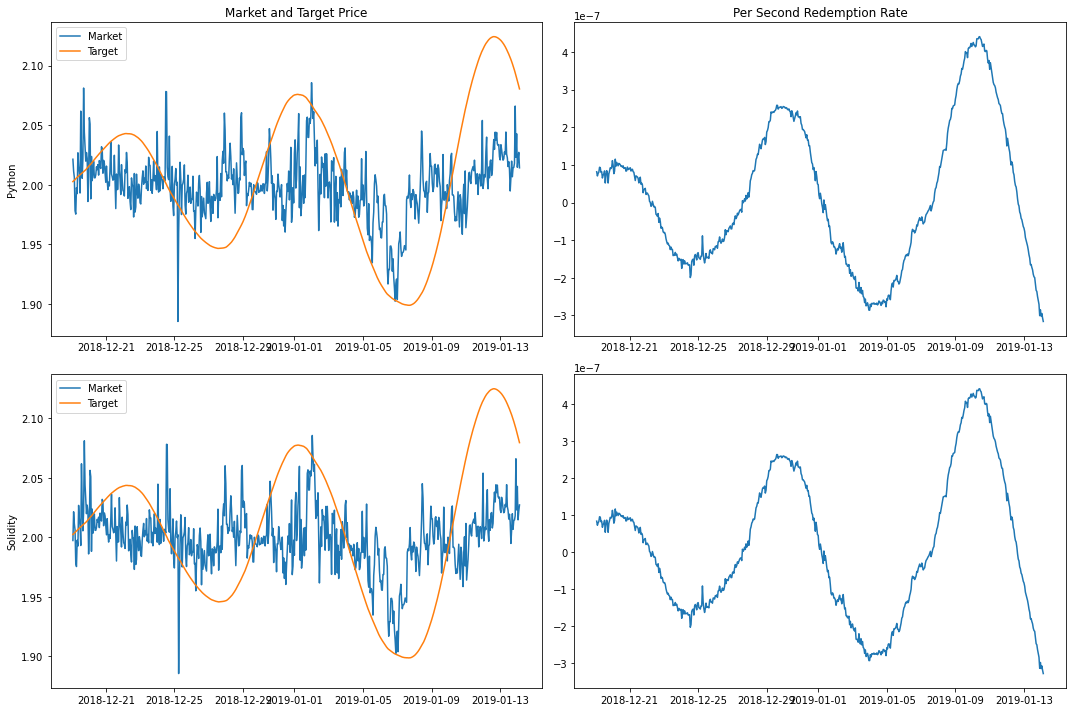

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,10))

i = 0
axs.flat[i].plot(combined['timestamp'], combined['market_price'], label='Market')
axs.flat[i].plot(combined['timestamp'], combined['target_price'], label='Target')
axs.flat[i].set_ylabel('Python')
axs.flat[i].set_title('Market and Target Price')
axs.flat[i].legend()

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['target_rate'])
axs.flat[i].set_title('Per Second Redemption Rate')

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['MarketPrice(USD)'], label='Market')
axs.flat[i].plot(combined['timestamp'], combined['RedemptionPrice(USD)'], label='Target')
axs.flat[i].legend()
axs.flat[i].set_ylabel('Solidity')

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['PerSecondRedemptionRate(float)'])

fig.tight_layout()
plt.show()
fig.savefig('plots/solidity-cadcad/solidity-cadcad-market.png')

<AxesSubplot:>

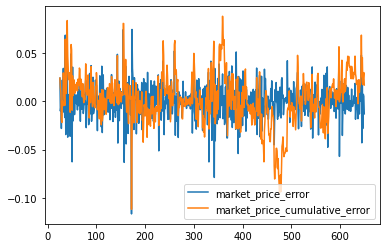

In [19]:
combined['market_price_error'] = combined['market_price'] - combined['MarketPrice(USD)']
combined['market_price_error'].plot(legend=True)
combined['market_price_cumulative_error'] = combined['market_price_error'].cumsum()
combined['market_price_cumulative_error'].plot(legend=True)

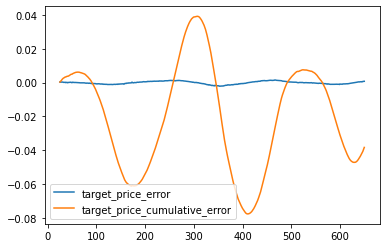

In [20]:
combined['target_price_error'] = combined['target_price'] - combined['RedemptionPrice(USD)']
combined['target_price_error'].plot(legend=True)
combined['target_price_cumulative_error'] = combined['target_price_error'].cumsum()
combined['target_price_cumulative_error'].plot(legend=True)
plt.savefig('plots/solidity-cadcad/solidity-cadcad-error.png')

In [21]:
print(f'''
Max error: {combined['target_price_error'].max()}
Std. error: {combined['target_price_error'].std()}
Mean error: {combined['target_price_error'].mean()}
Abs. mean error: {combined['target_price_error'].abs().mean()}
''')


Max error: 0.001571658132762943
Std. error: 0.000852125414183546
Mean error: -6.114025686875718e-05
Abs. mean error: 0.0007034128458034732



In [22]:
combined['target_price_cumulative_error'].describe()

count     626.000000
unique    626.000000
top        -0.046655
freq        1.000000
Name: target_price_cumulative_error, dtype: float64